# Bootstrapping: Emittance uncertainty calculation

In [1]:
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from random import seed

#### First, reading the raw data and displaying them in a dataframe.

In [2]:
I_meas, sigm = np.loadtxt('2_medida_emittance_planeX_E_147.8_MULTIBUNCH.txt', skiprows=2, unpack=True)
current, err_current, sigma,err_sigma  = [],[],[],[]
for i in range(0, len(I_meas), 4):
    current.append(np.mean(I_meas[i:i+4]))
    err_current.append(np.std(I_meas[i:i+4]))
    sigma.append(np.mean(sigm[i:i+4]))
    err_sigma.append(np.std(sigm[i:i+4]))
Data = pd.DataFrame({' Current [A]':current,
                     '$\pm$ uncert. [A]': err_current,
                     'Beam size [mm]':np.array(sigma)*1000,
                     '$\pm$ uncert. [mm]': np.array(err_sigma)*1000})
Data

,Current [A],$\pm$ uncert. [A],Beam size [mm],$\pm$ uncert. [mm]
0,0.599469,0.000463,0.841789,0.000379
1,0.680176,0.000608,0.810870,0.000358
2,0.759980,0.000768,0.781524,0.000427
3,0.839422,0.000189,0.759312,0.000159
4,0.919748,0.000872,0.746339,0.000348
5,0.999935,0.000570,0.738818,0.000750
6,1.079443,0.000543,0.742549,0.000190
7,1.160010,0.000788,0.753461,0.007116
8,1.240282,0.000468,0.763682,0.000262
9,1.319938,0.000763,0.797372,0.000028


#### Setting the experimental set-up data

In [3]:
I2K1 = [-0.0089, 2.1891, 0.0493] # Fitting values to transform from current to quadrupole strength
DIST = 2.8775                    # Space (drift) between the quadrupole and the camera
QUAD_L = 0.112                   # Quadrupole length
light_speed = 299792458          # in m/s
electron_rest_en = 0.5109989461  # in MeV
energy = 147.8                   # beam energy in MeV

In [4]:
def _get_K1_from_I(energy, I_meas):
    '''Function to calculate the quadrupole strength using the quadrupole current'''
    kin_en = np.sqrt(energy*energy - electron_rest_en*electron_rest_en)
    return np.polyval(I2K1, I_meas)*light_speed/kin_en/1e6

In [5]:
def _twiss(s_11 , s_12, s_22, energy):
    '''Funtion to calculate the normalize emittance and the 
       twiss parameters using the components of the emittance matrix'''
    emit = np.sqrt(abs(s_11 * s_22 - s_12 * s_12))
    beta = s_11 / emit
    alpha = -s_12 / emit
    gamma = s_22 / emit
    nemit = emit * energy / electron_rest_en * 1e6  # in mm.mrad
    return nemit, beta, alpha, gamma

In [6]:
def _trans_matrix_method(energy, I_meas, sigma, pl='x'):
    '''Function to calculate the beam emittance using transfer matrices'''
    K1 = _get_K1_from_I(energy,I_meas)
    Rx, Ry = _get_resp_mat(K1, energy)
    R = Rx if pl == 'x' else Ry
    pseudo_inv = np.dot(np.linalg.inv(np.dot(np.transpose(R) , R)) , np.transpose(R))
    [s_11, s_12, s_22] = pseudo_inv @ (sigma*sigma)
    #s_11, s_12, s_22 = np.linalg.lstsq(R, sigma * sigma, rcond=None)[0]
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [7]:
def quadratic_fit(x, y, correlation = False):
    '''
    Function to calculate the quadratic fitting parameters given 2 arrays
    '''
    x = np.array(x)
    y = np.array(y)
    x2 = x*x
    x_m = np.mean(x)
    y_m = np.mean(y)
    x2_m = np.mean(x2)
    sxx, sxy, sxx2, sx2x2, sx2y = 0, 0, 0, 0, 0
    for i in range(len(x)): 
        sxx += (x[i] - x_m)**2 
        sxy += (x[i] - x_m)*(y[i] - y_m) 
        sxx2 += (x[i] - x_m)*(x2[i] - x2_m) 
        sx2x2 += (x2[i] - x2_m)**2 
        sx2y += (x2[i] - x2_m)*(y[i] - y_m)  
    
    b = (sxy*sx2x2-sx2y*sxx2)/(sxx*sx2x2-sxx2*sxx2)
    c = (sx2y*sxx-sxy*sxx2)/(sxx*sx2x2-sxx2*sxx2)
    a = y_m - b*x_m - c*x2_m
    
    n, d = 0, 0
    for i in range(len(x)):
        n += (y[i] - (a + b*x[i]+c*x[i]*x[i]))**2
        d += (y[i]- y_m)**2
    r = np.sqrt(1-n/d)
    
    if correlation == True:
        return  c, b, a, r
    else: 
        return  c, b, a     

In [8]:
def _thin_lens_method(energy, I_meas, sigma, pl='x'):
    '''Function to calculate the beam emittance using the thin lens approximation 
      method with quadratic fitting parameters'''
    I_meas2 = I_meas if pl == 'x' else -I_meas
    K1 = _get_K1_from_I(energy,I_meas2)

    a, b, c = quadratic_fit(K1, sigma*sigma)
    
    d = DIST + QUAD_L/2
    l = QUAD_L
    s_11 = a/(d*l)**2
    s_12 = (-b-2*d*l*s_11)/(2*l*d*d)
    s_22 = (c-s_11-2*d*s_12)/d**2
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [9]:
def gettransmat(type, L, gamma, K1=None, B=None):
    '''Function to calculate a transfer matrix'''
    R = np.eye(6)

    if type.lower().startswith('qu') and K1 is not None and K1 == 0:
        type = 'drift'
    if type.lower().startswith('dr'):
        R = np.array([
            [1, L, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, L, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, L/gamma**2],
            [0, 0, 0, 0, 0, 1],
            ])
    elif type.lower().startswith('qu') and K1 is not None:
        kq = np.sqrt(abs(K1))
        c = np.cos(kq*L)
        s = np.sin(kq*L)
        ch = np.cosh(kq*L)
        sh = np.sinh(kq*L)
        if K1 > 0:
            x11, x12, x21 = c,  1/kq*s, -kq*s
            y11, y12, y21 = ch, 1/kq*sh, kq*sh
        else:
            x11, x12, x21 = ch, 1/kq*sh, kq*sh
            y11, y12, y21 = c,  1/kq*s, -kq*s
        R = np.array([
            [x11, x12, 0,   0,   0, 0],
            [x21, x11, 0,   0,   0, 0],
            [0,   0,   y11, y12, 0, 0],
            [0,   0,   y21, y11, 0, 0],
            [0,   0,   0,   0,   1, L/gamma**2],
            [0,   0,   0,   0,   0, 1],
            ])
    elif type.lower().startswith('sol') and B is not None:
        K = -light_speed*B/2.0/electron_rest_en/gamma/1e6
        C = np.cos(K*L)
        S = np.sin(K*L)
        SC = C*S
        C2 = C**2
        S2 = S**2
        R = np.array([
            [C2,    SC/K,  SC,    S2/K, 0., 0.],
            [-K*SC, C2,    -K*S2, SC,   0., 0.],
            [-SC,   -S2/K, C2,    SC/K, 0., 0.],
            [K*S2,  -SC,   -K*SC, C2,   0., 0.],
            [0.,    0.,    0.,    0.,   1., L/(gamma**2)],
            [0.,    0.,    0.,    0.,   0., 1.]
            ])
    return R

In [10]:
def _get_resp_mat(K1, energy):
    '''Function to calculate the total transfer matrix of the experiment'''
    gamma = energy/electron_rest_en
    R = np.zeros((len(K1), 6, 6))
    Rd = gettransmat('drift', L=DIST, gamma=gamma)
    for i, k1 in enumerate(K1):
        Rq = gettransmat('quad', L = QUAD_L, gamma=gamma, K1=k1)
        R[i] = np.dot(Rd, Rq)
    R11 = R[:, 0, 0].reshape(-1, 1)
    R12 = R[:, 0, 1].reshape(-1, 1)
    R33 = R[:, 2, 2].reshape(-1, 1)
    R34 = R[:, 2, 3].reshape(-1, 1)
    Rx = np.column_stack((R11*R11, 2*R11*R12, R12*R12))
    Ry = np.column_stack((R33*R33, 2*R33*R34, R34*R34))
    return Rx, Ry

In [11]:
def plot_histo(data_tm, data_tl,  xaxis= r'$\epsilon$ [mmm.rad]'):
    '''Function to plot two histograms with  their main properties'''

    plt.hist(data_tm, bins=50, range=[min(data_tm), max(data_tm)], fc='none',
            histtype='step', color='black', label='TM, $\mu$: '+str(round(data_tm.mean(),4))+' $\sigma$: '+
             str(round( np.std(data_tm),4)), linewidth=.8)
    
    plt.hist(data_tl, bins=50, range=[min(data_tl), max(data_tl)],  fc='none',
            histtype='step', color = 'maroon', label='TL, $\mu$: '+str(round(data_tl.mean(),4))+' $\sigma$: '+
             str(round( np.std(data_tl),4)), linewidth=.8)

    plt.legend(loc='lower right')
    plt.xlabel(xaxis, x=1, ha='right',size= 10 )
    plt.ylabel('amplitude', y=1, ha='right',size= 10)
    plt.show()

In [12]:
def emit_montec(energy, sigma, err_s, I, err_I, plane, M, plot = True):
    '''Function to resample the raw data and calculate the beam emittance uncertainty'''
    sigma_montecarlo = []
    
    #seed(30)
    nemit_t,beta_t, alpha_t,gamma_t =np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    nemit_tl, beta_tl, alpha_tl, gamma_tl = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    for m in range(M):
        sigma_mont_s = []
        I_mont_s = []
        for i in range(len(sigma)):
            sigma_mont_s.append(sigma[i] + err_s[i]*np.random.randn())
            I_mont_s.append(I[i] + err_I[i]*np.random.randn())
        sigma_mont_s = np.array(sigma_mont_s)
        nemit_t[m], beta_t[m],alpha_t[m],gamma_t[m] =  _trans_matrix_method(energy, I_mont_s, sigma_mont_s, pl=plane)
        nemit_tl[m], beta_tl[m], alpha_tl[m], gamma_tl[m] =_thin_lens_method(energy, I_mont_s, sigma_mont_s, pl=plane)

    if plot==True:
        sigma = np.array(sigma)*1000 # in mm
        error = np.array(err_s)*1000 # in mm
        K1 = _get_K1_from_I(energy, I) # in mm 
        err_K1 = _get_K1_from_I(energy, err_I)
        a1, b1, c1 = quadratic_fit(K1,sigma*sigma)
        K = np.linspace(min(K1), max(K1), 100)
        plt.plot(K , c1+b1*K+a1*K**2, '--', label = 'Quadratic fitting')
        plt.errorbar( K1,sigma*sigma, xerr = err_K1,  yerr= 2*error, fmt = 'ro', markersize = 3, 
                 ecolor = 'red', capsize = 3,  linewidth = 0.5, 
                 color = 'darkblue', label = "Experimental Data")
        plt.xlabel('K(I) [1/m$^2$]')
        plt.ylabel('Beam size$^2$ [mm$^2$]')
        plt.legend()
        plt.show()

        plot_histo(nemit_t, nemit_tl,  xaxis= r'$\epsilon$ [mm.mrad]')
        plot_histo(beta_t, beta_tl, xaxis= r'$\beta$ [m]')
        plot_histo(alpha_t, alpha_tl, xaxis= r'$\alpha$')
        plot_histo(gamma_t, gamma_tl,  xaxis= r'$\gamma$ [1/m]')
    
    return nemit_t, nemit_tl

#### Test of the Bootstrap method to calculate the emittance uncertainty

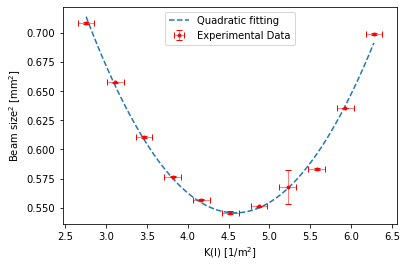

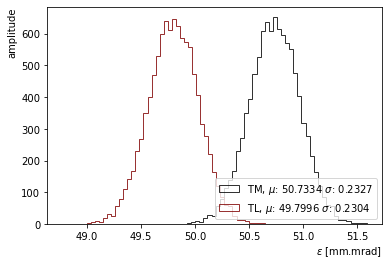

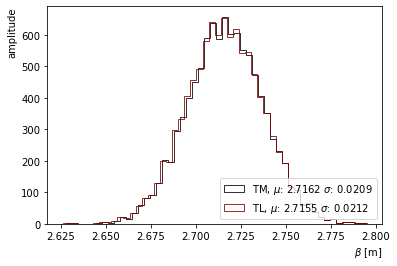

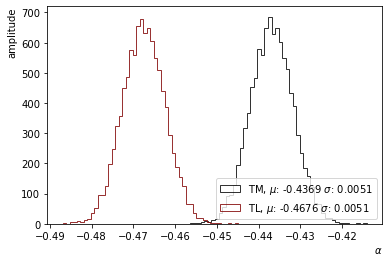

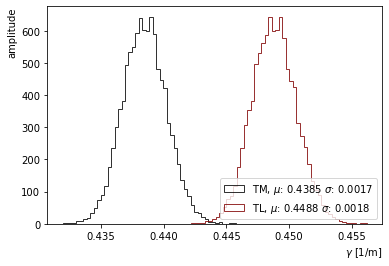

In [13]:
nemit_t, nemit_tl = emit_montec(energy, sigma, err_sigma, current, err_current, 'x', 10000, plot = True)

#### Compare the both methods differences in function of the number of random numbers

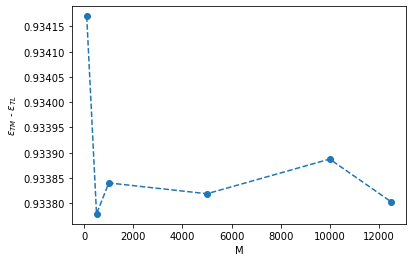

In [14]:
Ms = [100,500, 1000, 5000, 10000, 12500]
y0s = []
x0s = []
for k in Ms:
    nemit_t, nemit_tl = emit_montec(energy, sigma,err_sigma, current, err_current, 'x', k, plot = False)
    y0s.append(np.abs(np.mean(nemit_t)- np.mean(nemit_tl)))

plt.plot(Ms, y0s, "o--")
plt.xlabel('M')
plt.ylabel('$\epsilon_{TM}$ - $\epsilon_{TL}$')
plt.show()